In [10]:
# !pip install scanpy
import pandas as pd
import scanpy as sc

adata = sc.read_10x_mtx(
    "../../../Downloads/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/Users/onur-lumc/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


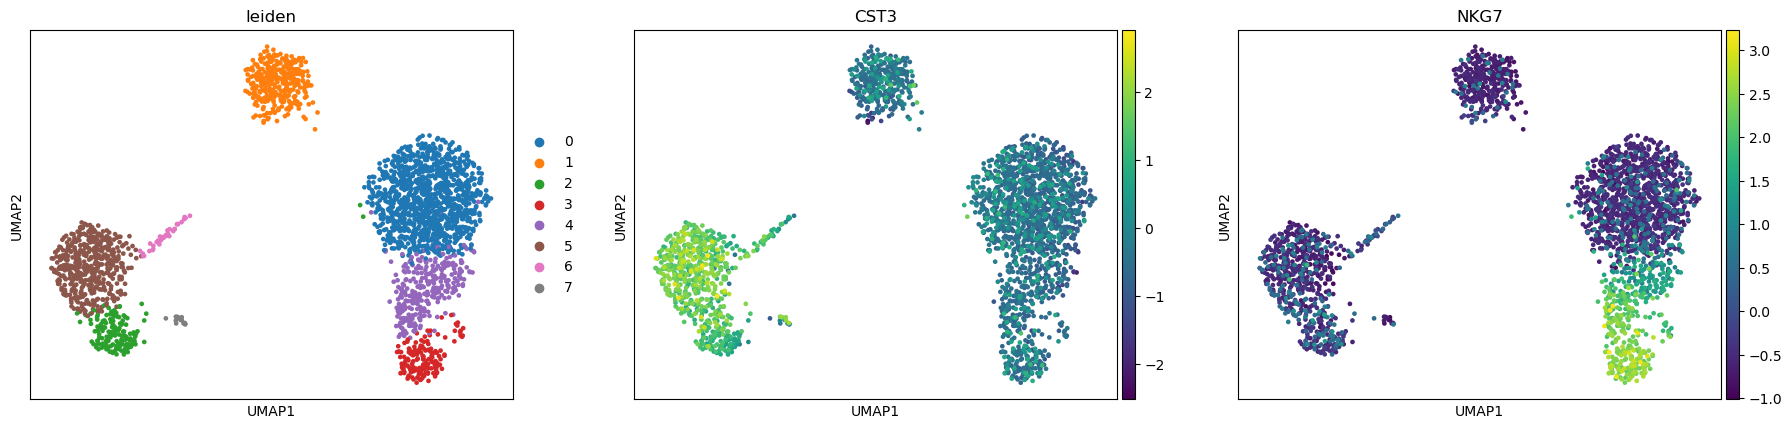

In [12]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])


In [13]:
adata_raw = adata.raw.to_adata() if adata.raw is not None else adata
# Replace zero or negative values with a small positive number
small_positive_value = 1e-10
adata_raw.X[adata_raw.X <= 0] = small_positive_value

# Update adata.raw if necessary
if adata.raw is not None:
    adata.raw = adata_raw


In [33]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")

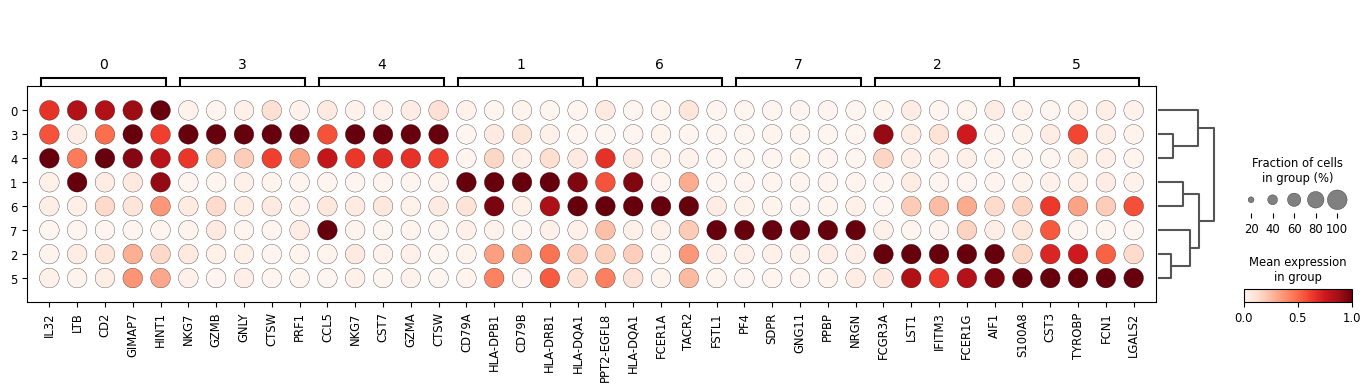

In [15]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5,  
)

Find marker genes:

In [16]:
# Extract the DEGs from adata
degs = adata.uns['rank_genes_groups']

# Get the clusters (groups)
clusters = degs['names'].dtype.names

# Initialize the marker list
marker_list = {}

# Loop through each cluster and extract the top DEGs
for cluster in clusters:
    genes = degs['names'][cluster]
    log2fc = degs['logfoldchanges'][cluster]
    pvals_adj = degs['pvals_adj'][cluster]
    
    # Create a DataFrame for each cluster
    df = pd.DataFrame({'gene': genes, 'avg_log2FC': log2fc, 'pvals_adj': pvals_adj})
    
    # Store the DataFrame in the marker list dictionary
    marker_list[cluster] = df


In [17]:
from main import *

In [28]:
ann = ceLLama(marker_list, n_genes=10, )

>> Response: T cells (CD4+ T cells)
>> Response: B cells
>> Response: Plasmacytoid dendritic cells (pDCs)
>> Response: CD8+ T cells (Tc1/Tc2)
>> Response: CD8+ T cells
>> Response: Neutrophil
>> Response: Macrophage/Monocyte
>> Response: CD8+ T cells


In [29]:
new_cluster_names = []
for el in ann.keys():
    new_cluster_names.append(f"{el}: {ann[el]['annotation']}")

new_cluster_names

adata.rename_categories("leiden", new_cluster_names)


['0: T cells (CD4+ T cells)',
 '1: B cells',
 '2: Plasmacytoid dendritic cells (pDCs)',
 '3: CD8+ T cells (Tc1/Tc2)',
 '4: CD8+ T cells',
 '5: Neutrophil',
 '6: Macrophage/Monocyte',
 '7: CD8+ T cells']

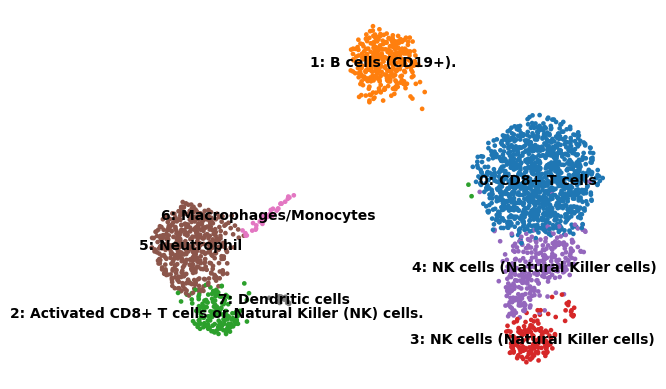

In [27]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False,
)